In [3]:

%matplotlib inline

Toy problem
Suppose we want to fit a third order polynomial to predict
 in the interval
.

Let's start out by generating some training data
, where
 iterates over the
 training samples.

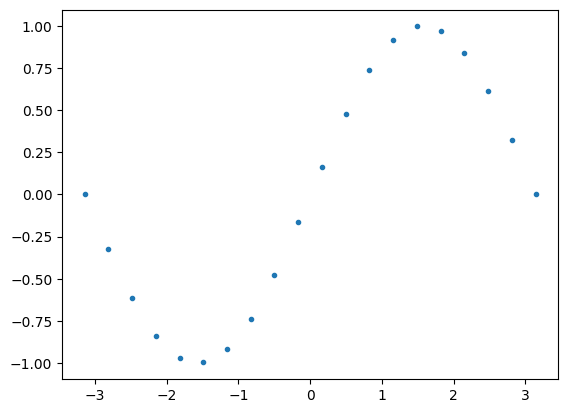

In [4]:
import torch
import math
from matplotlib import pyplot as plt
import numpy as np

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
N = 20
x = torch.linspace(-math.pi, math.pi, N, dtype=dtype)
y = torch.sin(x)
plt.plot(x.numpy(),y.numpy(),'.')

Manual derivatives
Now, let's fit the training data using a third order polynomial by minimizing the L2 norm.

Writing the i'th prediction as
, we would like our model to output
.

Manually calculating the partial derivatives of the loss function w.r.t.
,
,
, and
 would not a big deal for this toy example. We just need to differentitate the loss function


where we are summing over the training samples.

Applying the chain rule a few times, we can easily show that









We now have what we need to fit the polynomial using gradient descent.

Your task: Fill in the gaps below (marked with ???) and run the code.

99 1.8164280652999878
199 1.2653177976608276
299 0.89536452293396
399 0.6463482975959778
499 0.47828149795532227
599 0.3645457923412323
699 0.28737515211105347
799 0.2348792552947998
899 0.19907836616039276
999 0.17460431158542633
1099 0.15783391892910004
1199 0.14631590247154236
1299 0.13838860392570496
1399 0.1329212784767151
1499 0.12914317846298218
1599 0.12652753293514252
1699 0.1247137039899826
1799 0.1234537735581398
1899 0.12257716059684753
1999 0.12196657061576843
Result: y = 0.01194727048277855 + 0.8316217660903931 x + -0.0018654867308214307 x^2 + -0.08788656443357468 x^3


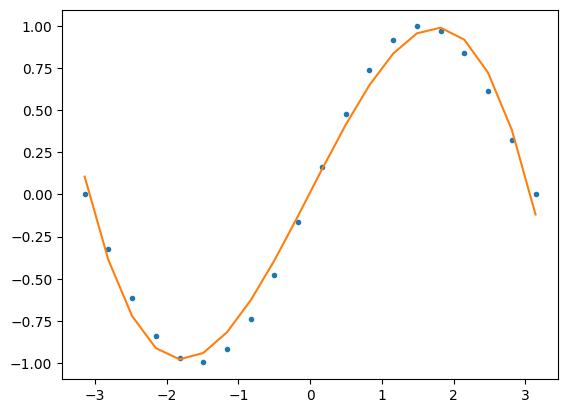

In [5]:
# Create random Tensors for weights.
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-4
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Compute gradients of loss w.r.t. a, b, c, and d
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a = a - learning_rate * grad_a
    b = b - learning_rate * grad_b
    c = c - learning_rate * grad_c
    d = d - learning_rate * grad_d

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')
plt.plot(x.numpy(),y.numpy(),'.',x.numpy(),y_pred.detach().numpy())

Automatic differentiation
Manual differentiation can quickly get very hairy for large complex networks. Thankfully, we can use automatic differentiation to automate the computation of backward passes in our model (or neural network). The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your model will define a computational graph; nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

This sounds complicated, it’s pretty simple to use in practice. Each Tensor represents a node in a computational graph. If x is a Tensor that has x.requires_grad=True then x.grad is another Tensor holding the gradient of x with respect to some scalar value.

Here we use PyTorch Tensors and autograd to implement our fitting sine wave with third order polynomial example; now we don't need to manually implement the backward pass through the model.

Your task: Uncomment the correct backward() call and fill in the gaps marked with ???.

99 7.45933723449707
199 5.214546203613281
299 3.661932945251465
399 2.5861454010009766
499 1.8394901752471924
599 1.320457100868225
699 0.9591233134269714
799 0.707231879234314
899 0.5314111709594727
999 0.40854430198669434
1099 0.3225897252559662
1199 0.2623976469039917
1299 0.22020778059959412
1399 0.19061121344566345
1499 0.16983288526535034
1599 0.15523532032966614
1699 0.14497295022010803
1799 0.1377541422843933
1899 0.1326737403869629
1999 0.1290963590145111
Result: y = -0.03052547015249729 + 0.8304088711738586 x + 0.0047663538716733456 x^2 + -0.08772937208414078 x^3


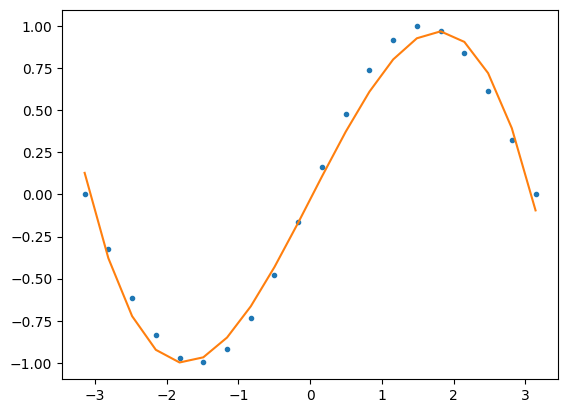

In [6]:
# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-4
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of the loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')
plt.plot(x.numpy(),y.numpy(),'.',x.numpy(),y_pred.detach().numpy())

Defining New autograd Functions
Instead of writing the polynomial as
, we might want to write it as
 where

 is the Legendre polynomial of degree three.

This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients.

All we need to enable autograd is to implement a backward pass that calculates the local gradient,

.

Question: What's the point of this? Read the answer in the next section.

99 1.4355472326278687
199 0.7337876558303833
299 0.40682584047317505
399 0.4784679412841797
499 0.4625204801559448
599 0.542697548866272
699 0.2203645408153534
799 0.6270391941070557
899 0.18154898285865784
999 0.7319380640983582
1099 0.2053001970052719
1199 0.15018948912620544
1299 0.2176140546798706
1399 0.2004535049200058
1499 0.42892348766326904
1599 0.3235528767108917
1699 0.1922249048948288
1799 2.0524470806121826
1899 0.3988965153694153
1999 0.7007541060447693
Result: y = -5.513435819004542e-10 + -2.0981671810150146 * P3(1.2516974123855107e-09 + 0.20071791112422943 x)


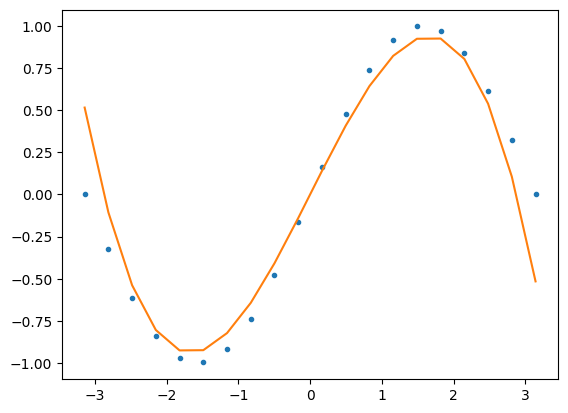

In [7]:
import torch
import math

class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)

# Create random Tensors for weights. For this example, we need
# 4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
# not too far from the correct result to ensure convergence.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-3
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = LegendrePolynomial3.apply

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')
plt.plot(x.numpy(),y.numpy(),'.',x.numpy(),y_pred.detach().numpy())

Chain rule in a neuron
We can imagine a neural network as a massive computational graph. PyTorch automatically sets up that graph for us.

Let us say we have a “neuron” f in that computational graph with inputs
 and
 which outputs
.

We can easily compute the local gradients — differentiating
 with respect to
 and
 as

 and

.

From the forward pass, we obtain the loss (
).

When we start to work the loss backwards, we get the gradient of the loss from the layer above


In order for the loss to be propagated backwards, we need to find

 and

.

These can be calculated using the chain rule, i.e.,



 and




picture

So what is the point of all this?

All we need to build computational graphs that enable automatic differentiation is to define a forward function and a backward function for each of the basic operations (or neurons) we want in our model. We only need to do this once per operation, thereby avoiding the need for manual differentiation everytime we change the architecture of our model.

The forward function calculates the output (
).

The backward function calculates the local gradients (e.g.,

 and

).

All the rest is taken care of by applying the chain rule, as explained above.

In the example from before, we defined those two functions for a Legendre polynomial of degree three. Having defined this neuron/operation once, we can use it as a building block to build models that can be automatically differentiated.

PyTorch, of cause, comes with such an implementation for all the common building blocks, such as multiplication, addition, sigmoid, convolution, etc.